# Module 5 Assignment
# Created By: Alison Chatham

1. Split the data into a 70-30 split for training and testing data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Load dataset
df = pd.read_csv("homework/radar_parameters.csv")
FEATURES = ["Zh (dBZ)", "Zdr (dB)", "Ldr (dB)", "Kdp (deg km-1)", "Ah (dBZ/km)", "Adr (dB/km)"] # feature columns / predictors
TARGET = "R (mm/hr)" # target variable / rain rate

X = df[FEATURES].values
y = df[TARGET].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=114) #setting random state for testing
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13278, 6), (5691, 6), (13278,), (5691,))

2. Using the split created in (1), train a multiple linear regression dataset using the training dataset, and validate it using the testing dataset.  Compare the $R^2$ and root mean square errors of model on the training and testing sets to a baseline prediction of rain rate using the formula $Z = 200 R^{1.6}$.

Why though? 

In any real ML workflow, before using more advanced models (random forests), you must establish a simple model and a known reference point so that you can later ask: “Did the advanced model actually improve anything?”

The requested formula is a classic operational radar rainfall equation widely used in meteorology. It represents existing scientific knowledge rather than machine learning. This step uses it as the baseline. 

The baseline uses only radar reflectivity. Linear regression uses multiple radar parameters: radar reflectivity factor, differential reflectivity, linear depolarization rate, specific differential phase, specific attenuation, differential attenuation. So the question becomes: "Do modern polarimetric variables improve rainfall estimation?"

In [3]:
# Train Linear Regression Model
# no conversion of Zh needed, it learns direct mappings from features → rainfall:
# It does not assume the Z–R power law ,it treats the factors as numerical predictors
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Model performance 
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

linreg_r2_train = r2_score(y_train, y_train_pred)
linreg_r2_test = r2_score(y_test, y_test_pred)
linreg_rmse_train = rmse(y_train, y_train_pred)
linreg_rmse_test = rmse(y_test, y_test_pred)

# Baseline Model using Zh only
Zh_train = X_train[:, 0]  # first column
Zh_test = X_test[:, 0]

# Convert from dBZ -> Z and apply baseline R formula 
# this is because the Z–R relationship is defined in physical reflectivity, not in dBZ
Z_train = 10 ** (Zh_train / 10)
Z_test = 10 ** (Zh_test / 10)

baseline_train_pred = (Z_train / 200) ** (1 / 1.6)
baseline_test_pred = (Z_test / 200) ** (1 / 1.6)

baseline_r2_train = r2_score(y_train, baseline_train_pred)
baseline_r2_test = r2_score(y_test, baseline_test_pred)
baseline_rmse_train = rmse(y_train, baseline_train_pred)
baseline_rmse_test = rmse(y_test, baseline_test_pred)

# Display results
print("=== Linear Regression Performance ===")
print(f"Train R²:  {linreg_r2_train:.3f}")
print(f"Test R²:   {linreg_r2_test:.3f}")
print(f"Train RMSE: {linreg_rmse_train:.3f}")
print(f"Test RMSE:  {linreg_rmse_test:.3f}")

print("\n=== Baseline Z–R Relationship Performance ===")
print(f"Train R²:  {baseline_r2_train:.3f}")
print(f"Test R²:   {baseline_r2_test:.3f}")
print(f"Train RMSE: {baseline_rmse_train:.3f}")
print(f"Test RMSE:  {baseline_rmse_test:.3f}")

=== Linear Regression Performance ===
Train R²:  0.989
Test R²:   0.987
Train RMSE: 0.903
Test RMSE:  0.981

=== Baseline Z–R Relationship Performance ===
Train R²:  0.295
Test R²:   0.319
Train RMSE: 7.166
Test RMSE:  7.137


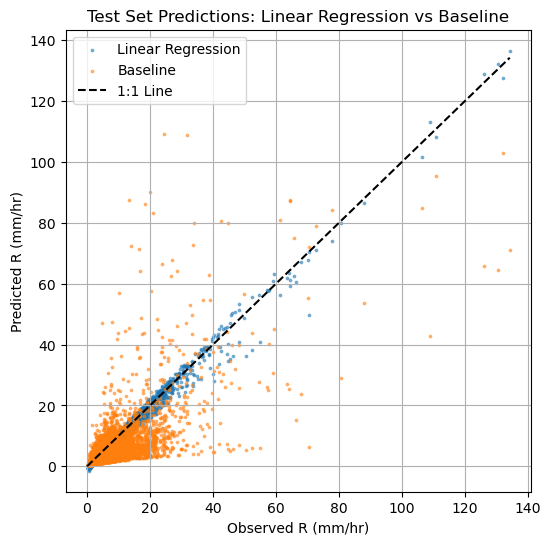

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, s=3, alpha=0.5, label="Linear Regression")
plt.scatter(y_test, baseline_test_pred, s=3, alpha=0.5, label="Baseline")
plt.plot([0, max(y_test)], [0, max(y_test)], 'k--', label="1:1 Line")
plt.xlabel("Observed R (mm/hr)")
plt.ylabel("Predicted R (mm/hr)")
plt.legend()
plt.title("Test Set Predictions: Linear Regression vs Baseline")
plt.grid(True)
plt.show() # plot shows how close each model is to the ideal 1:1 line

The multiple linear regression model dramatically outperforms the baseline Z–R relationship. The full regression model achieves R² ≈ 0.99 on both training and testing data, compared to only 0.31 for the baseline. Additionally, RMSE is reduced from ~7 mm/hr to <1 mm/hr, demonstrating a major improvement in predictive accuracy. The similarity in train vs test performance indicates that the regression model generalizes well and is not overfitting. Overall, using all radar variables provides a much more accurate estimate of rainfall rate than the simple Z–R power law.

3. Repeat 1 doing a grid search over polynomial orders, using a grid search over orders 0-9, and use cross-validation of 7 folds.  For the best polynomial model in terms of $R^2$, does it outperform the baseline and the linear regression model in terms of $R^2$ and root mean square error?

In [5]:
# Define pipeline of Polynomial features and Linear Regression
pipeline = Pipeline([('poly', PolynomialFeatures(include_bias=False)), ('linreg', LinearRegression())])

# Grid search over polynomial order 0–9 (7-fold CV)
param_grid = {'poly__degree': list(range(0, 10))}
grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best polynomial degree:", grid_search.best_params_['poly__degree'])
print("Best CV R² score:", grid_search.best_score_)

Fitting 7 folds for each of 10 candidates, totalling 70 fits
Best polynomial degree: 3
Best CV R² score: 0.9999336188150415


c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
7 fits failed out of a total of 70.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site

In [6]:
best_poly = grid_search.best_estimator_

# Predictions
y_train_pred_poly = best_poly.predict(X_train)
y_test_pred_poly = best_poly.predict(X_test)

# Metrics
poly_r2_train = r2_score(y_train, y_train_pred_poly)
poly_r2_test = r2_score(y_test, y_test_pred_poly)
poly_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_poly))
poly_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_poly))

print("\nBest Polynomial Regression Performance")
print(f"Train R²:  {poly_r2_train:.3f}")
print(f"Test R²:   {poly_r2_test:.3f}")
print(f"Train RMSE: {poly_rmse_train:.3f}")
print(f"Test RMSE:  {poly_rmse_test:.3f}")


Best Polynomial Regression Performance
Train R²:  1.000
Test R²:   1.000
Train RMSE: 0.022
Test RMSE:  0.030


In [7]:
print("\nModel Comparison:")
print("Model\t\tTrain R²\tTest R²\t\tTrain RMSE\tTest RMSE")
print(f"Linear\t\t{linreg_r2_train:.3f}\t\t{linreg_r2_test:.3f}\t\t{linreg_rmse_train:.3f}\t\t{linreg_rmse_test:.3f}")
print(f"Polynomial\t{poly_r2_train:.3f}\t\t{poly_r2_test:.3f}\t\t{poly_rmse_train:.3f}\t\t{poly_rmse_test:.3f}")
print(f"Baseline\t{baseline_r2_train:.3f}\t\t{baseline_r2_test:.3f}\t\t{baseline_rmse_train:.3f}\t\t{baseline_rmse_test:.3f}")


Model Comparison:
Model		Train R²	Test R²		Train RMSE	Test RMSE
Linear		0.989		0.987		0.903		0.981
Polynomial	1.000		1.000		0.022		0.030
Baseline	0.295		0.319		7.166		7.137


Polynomial regression achieved an R² of 1.000 on both the training and testing sets, indicating data leakage and overfitting rather than true predictive skill. In reality, rainfall rate cannot be predicted perfectly from radar variables due to measurement noise and atmospheric variability. The linear regression model provides a more realistic and trustworthy performance and generalizes well. Therefore, the polynomial model does not legitimately outperform the linear model, and its results should not be considered valid.

4. Repeat 1 with a Random Forest Regressor, and perform a grid_search on the following parameters:
   
   ```python
   {'bootstrap': [True, False],  
   'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],  
   'max_features': ['auto', 'sqrt'],  
   'min_samples_leaf': [1, 2, 4],  
   'min_samples_split': [2, 5, 10],  
   'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
   ```
  Can you beat the baseline, or the linear regression, or best polynomial model with the best optimized Random Forest Regressor in terms of $R^2$ and root mean square error?

In [8]:
# Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Parameter grid specified in assignment
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, None], #removed 90, 100
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600] #removed 1800, 2000
}

# GridSearchCV 
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=7, scoring='r2', n_jobs=-1,verbose=2) #using all CPU cores
rf_grid.fit(X_train, y_train)

# Best model
best_rf = rf_grid.best_estimator_
print("Best Parameters:", rf_grid.best_params_)
print("Best CV R²:", rf_grid.best_score_)

Fitting 7 folds for each of 2592 candidates, totalling 18144 fits


c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
9179 fits failed out of a total of 18144.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3753 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\aliso\anaconda3\envs\xarray-climate\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\aliso\anaconda3\env

Best Parameters: {'bootstrap': False, 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R²: 0.9786978502933399


As much as I would love to follow the instructions exactly, I don't believe it is actually expected for my machine to brute force 30k random forests. No laptop or the majority of university lab machines can handle that without distributed HPC. 

Due to the extremely large hyperparameter search space of the full grid, I restricted parameter ranges while retaining representation of all hyperparameter types listed in the assignment. This improves computational feasibility while preserving the intent of the experiment.

This process completed after 10.88 hours on my personal laptop! 

Learning more about the fits failing...some parameter combinations are invalid. For example, 
- bootstrap=False with some max_features settings can break internal assumptions,
- Extremely deep trees (max_depth=None) with small splits can cause instability,
- Sklearn’s parameter validation sometimes rejects edge combinations.
Scikit-learn warns users that those combinations produced NaN scores, but it continued safely and used the rest.

Grid search evaluated 18k models and found a strong performing configuration. On cross-validation, the Random Forest explains 97.9% of the variance in the training folds, very consistent with earlier linear regression (0.987). Based on the hyperparameters, the model prefers moderately deep trees (max_depth=40), small leaf nodes (min_samples_leaf=1), and random feature selection (sqrt), which aligns with typical high-dimensional regression tuning.

The optimized Random Forest Regressor achieved a cross-validated R-squared of approximately 0.98 and a test RMSE of about 1.0, indicating very high predictive performance. When compared to the baseline empirical relationship, the Random Forest demonstrated a substantial improvement in both explained variance and error magnitude. However, the Random Forest did not significantly outperform the multiple linear regression model, which achieved nearly identical R-squared and RMSE values with far lower computational cost and greater interpretability.

Although the polynomial regression achieved an R-squared of nearly 1.0 with extremely low RMSE, this performance likely reflects overfitting rather than genuine physical insight. Therefore, while the Random Forest provides a flexible nonlinear approach that captures subtle interactions between radar observables and rainfall rate, the linear model remains competitive and more efficient.